In [1]:
import copy
import scipy
import numpy as np
import matplotlib.pyplot as plt

In [2]:
DECIMATED_RATE = 6000

In [3]:
FILENAME = "./audio/20250710-2057.wav"

In [32]:
# Constant used for tuning, I don't know why I'm always some degrees off, I
# think that I'm doing the calculations for the delays of each filter wrong, or
# something like that. I don't have time to fix it now so I just add this number
# to the angle
ANGLE_OFFSET = 114

In [5]:
class Signal:

    def __init__(self, samples, rate, delay=0):
        """
        Keeps the data of a signal and sample rate tied together.

        Also keeps track of the delay that this signal has, each FIR filter adds
        a delay of N/2 being N the number of taps. At the end I need the delays
        of each signal to compare the phase of them.
        """
        self.samples = samples
        self.rate = rate
        self.delay = delay

In [6]:
def lowpass(signal, width, attenuation, f):
    """
    FIR lowpass filter.

    Updates the delay attribute of the Signal object, indicating the delay that
    this filter has created.

    Arguments:
    - signal: Signal object
    - width [Hz]: Transition band width
    - attenuation [dB]: Positive decibels
    - f [Hz]: Cutoff frequency
    """

    nyq_rate = signal.rate / 2

    # Convert to normalized units (where 1 is the maximum frequency, equal to pi
    # radians per second, or equal to rate/2)
    width_norm = width/nyq_rate
    f_norm = f/nyq_rate

    N, beta = scipy.signal.kaiserord(attenuation, width_norm)

    # I prefer filters with odd number of taps
    if N % 2 == 0:
        N += 1

    # Design filter
    taps = scipy.signal.firwin(N, f_norm, window=("kaiser", beta))
    print("Lowpass filtering with {} taps".format(N))

    # Filter and create new Signal object
    result = Signal(
        scipy.signal.lfilter(taps, 1.0, signal.samples),
        signal.rate,
        signal.delay + (N - 1) // 2
    )
    return result

In [7]:
def bandpass(signal, width, attenuation, f1, f2):
    """
    Bandpass, leaves frequencies between f1 and f2

    Arguments:
    - signal
    - width [Hz]: Transition band width
    - attenuation [dB]: Positive decibels
    - f1 [Hz]: Cutoff frequency 1
    - f2 [Hz]: Cutoff frequency 2
    """

    nyq_rate = signal.rate / 2

    # Convert to normalized units (where 1 is the maximum frequency, equal to pi
    # radians per second, or equal to rate/2)
    width_norm = width/nyq_rate
    f1_norm = f1/nyq_rate
    f2_norm = f2/nyq_rate

    N, beta = scipy.signal.kaiserord(attenuation, width_norm)

    # I prefer filters with odd number of taps
    if N % 2 == 0:
        N += 1

    # Design filter
    taps = scipy.signal.firwin(
        N,
        [f1_norm, f2_norm],
        window=("kaiser", beta),
        pass_zero=False
    )
    print("Bandpass filtering with {} taps".format(N))

    # Filter and create new Signal object
    result = Signal(
        scipy.signal.lfilter(taps, 1.0, signal.samples),
        signal.rate,
        signal.delay + (N - 1) // 2
    )
    return result

In [8]:
def plot_signal(signal, title):
    """
    Plots a signal as a function of time and frequency.

    Arguments:
    - signal: Signal object
    - title: Description of the signal

    Reference: https://glowingpython.blogspot.com/2011/08/how-to-plot-frequency-spectrum-with.html
    """

    fig = plt.figure(title)
    axes_time, axes_freq = fig.subplots(2, 1)

    samples = signal.samples

    n = len(samples)
    k = np.arange(n)
    T = n / signal.rate

    # Two sides frequency range
    frq = k / T
    # One side frequency range
    frq = frq[range(n // 2)]
    # Time range
    t = k / signal.rate

    # FFT computing and normalization
    Y = scipy.fft.fft(samples) / n
    # Keep only one side
    Y = Y[range(n // 2)]

    # Delay in seconds
    delay_s = signal.delay / signal.rate

    axes_time.plot(t, samples, "b")
    axes_time.set_title("{}: Time".format(title))
    axes_time.set_xlabel("Time (seconds), delay: {}s".format(delay_s))
    axes_time.set_ylabel("y(t)")
    axes_time.grid(True)

    axes_freq.plot(frq, abs(Y), "r") # plotting the spectrum
    axes_freq.set_title("{}: Frequency".format(title))
    axes_freq.set_xlabel("Freq (Hz)")
    axes_freq.set_ylabel("|Y(f)|")
    axes_freq.grid(True)
    plt.show()

In [9]:
def decimate(signal, output_rate):
    """
    Decimate to reach a given sample rate.

    Raises exception when input and output rate are not divisible.
    """
    assert signal.rate % output_rate == 0
    factor = signal.rate // output_rate

    result = Signal(
        signal.samples[::factor],
        output_rate,
        signal.delay // factor
    )
    return result


In [22]:
def compare_phases(ref_signal, var_signal):
    """
    Compare the phase of te reference and variable signals.

    Returns the difference, which should be the location of the receiver respect
    to the VOR transmitter.
    """
    assert ref_signal.rate == var_signal.rate
    rate = ref_signal.rate

    # Copy signals so I do not modify the objects given by the caller
    ref_signal = copy.copy(ref_signal)
    var_signal = copy.copy(var_signal)

    # Remove delays
    # Each succesive FIR filter adds a delay to the samples, so I store in the
    # signal object the delay in samples of each operation. Now I just cut the
    # start of the signal accordingly to leave both signals correctly aligned on
    # time
    ref_signal.samples = ref_signal.samples[ref_signal.delay:]
    ref_signal.delay = 0
    var_signal.samples = var_signal.samples[var_signal.delay:]
    var_signal.delay = 0

    # Correct the delay on the var_signal, I don't know why
    delay = int(ANGLE_OFFSET / 360 * 1/30 * rate)
    var_signal.samples = var_signal.samples[delay:]

    # Cut the variable signal if necessary, because if the are the same length
    # we can't do valid correlations. At least leave a difference of 4 periods
    var_max_length = int(len(ref_signal.samples) - rate * 4 / 30)
    if len(var_signal.samples) > var_max_length:
        var_signal.samples = var_signal.samples[:var_max_length]

    # Get the angle difference
    # I'm doing the correlation between both signals and then I take a look at
    # the maximum
    corr = np.correlate(ref_signal.samples, var_signal.samples, "valid")
    # Offset between signals in seconds
    offset = corr.argmax() / rate
    bearing = (offset / (1/30) * 360)
    bearing = bearing % 360

    fig = plt.figure("Phase comparison")
    axes_signals, axes_corr = fig.subplots(2, 1)

    # Normalize both signals a bit so the plot looks better
    ref_signal.samples = ref_signal.samples / abs(ref_signal.samples.max())
    var_signal.samples = var_signal.samples / abs(var_signal.samples.max())

    n = len(ref_signal.samples)
    t = np.arange(n) / rate

    axes_signals.plot(
        t[:len(ref_signal.samples)],
        ref_signal.samples,
        "b", label="Reference"
    )
    axes_signals.plot(
        t[:len(var_signal.samples)],
        var_signal.samples,
        "r",
        label="Variable"
    )
    axes_signals.set_title("Phase comparison")
    axes_signals.set_xlabel("Time (seconds)")
    axes_signals.set_ylabel("y(t)")
    axes_signals.legend()
    axes_signals.grid(True)

    n = len(corr)
    t = np.arange(n) / rate

    axes_corr.plot(t, corr, "b")
    axes_corr.set_title("Correlation")
    axes_corr.set_xlabel("Time (seconds)")
    axes_corr.set_ylabel("correlation")
    axes_corr.grid(True)

    return bearing

In [11]:
def get_audio_stats(samples, rate):
    """
    Returns the sample rate and number of samples in the audio file.
    """
    if not isinstance(samples, np.ndarray):
        raise TypeError("Samples must be a numpy array")
    if not isinstance(rate, int):
        raise TypeError("Rate must be an integer")

    print("Input sample rate:", rate)
    print("Input samples:", len(samples))
    print("Recording duration: {:.2f} seconds".format(len(samples) / rate))

In [12]:
# Load input from wav
rate, samples = scipy.io.wavfile.read(FILENAME)
if samples.ndim > 1:
    # Keep only one channel if audio is stereo
    samples = samples[:, 0]
input_signal = Signal(samples, rate)
get_audio_stats(samples, rate)

Input sample rate: 96000
Input samples: 225757
Recording duration: 2.35 seconds


In [13]:
# If the recording is longer than 1 second, decimate it to speed up the processing
if len(samples) / rate > 1:
    samples = samples[:rate]
    input_signal = Signal(samples, rate)
    get_audio_stats(samples, rate)
else:
    print("Recording is shorter than 1 second, not decimating")

Input sample rate: 96000
Input samples: 96000
Recording duration: 1.00 seconds


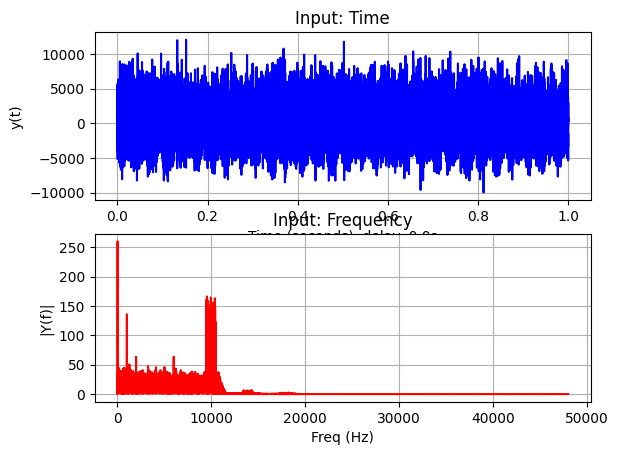

In [14]:
plot_signal(input_signal, "Input")

Lowpass filtering with 699 taps


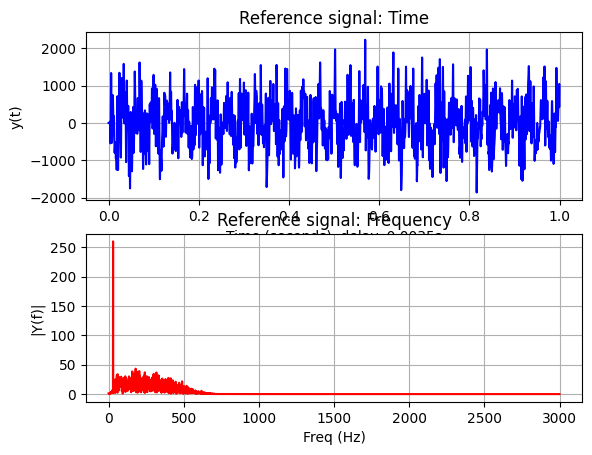

In [15]:
# Filter and decimate reference signal, a 30Hz tone
ref_signal = lowpass(
    input_signal,
    width=500,
    attenuation=60,
    f=500
)
ref_signal = decimate(ref_signal, DECIMATED_RATE)
plot_signal(ref_signal, "Reference signal")

Bandpass filtering with 351 taps


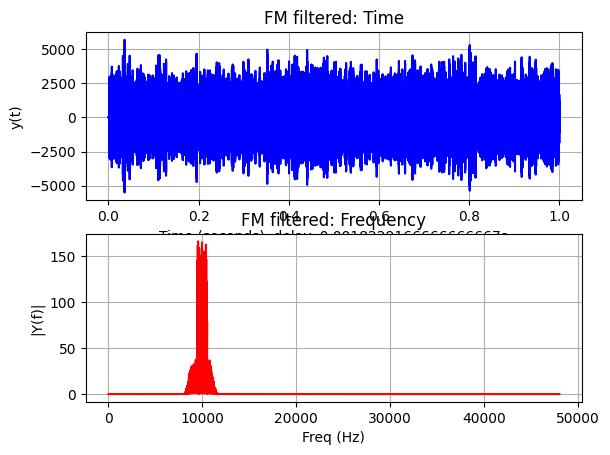

In [16]:
# Filter FM signal
fm_signal = bandpass(
    input_signal,
    width=1000,
    attenuation=60,
    f1=8500,
    f2=11500
)
plot_signal(fm_signal, "FM filtered")

C:\Users\iu2frl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\iu2frl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


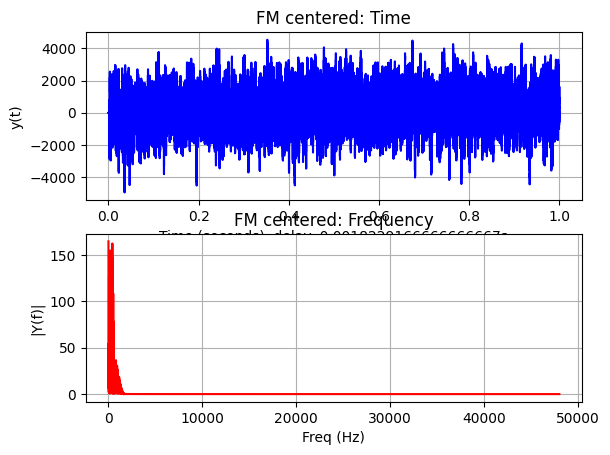

In [17]:
# Center FM signal on 0Hz
carrier = np.exp(-1.0j*2.0*np.pi*9960/fm_signal.rate*np.arange(len(fm_signal.samples)))
fm_signal.samples = fm_signal.samples * carrier
plot_signal(fm_signal, "FM centered")

Lowpass filtering with 699 taps


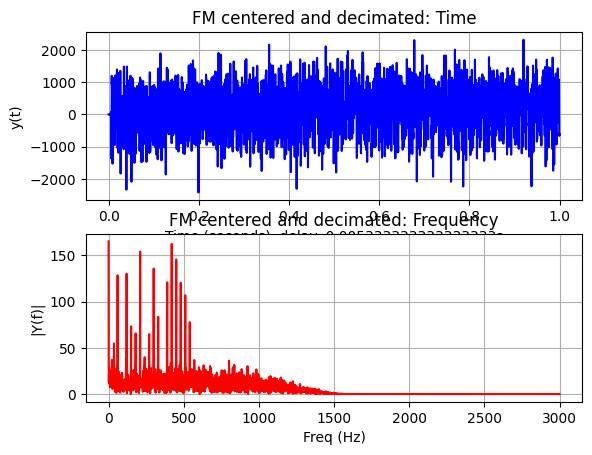

In [18]:
# Lowpass and decimate FM signal
fm_signal = lowpass(
    fm_signal,
    width=500,
    attenuation=60,
    f=1500
)

fm_signal = decimate(fm_signal, DECIMATED_RATE)
plot_signal(fm_signal, "FM centered and decimated")

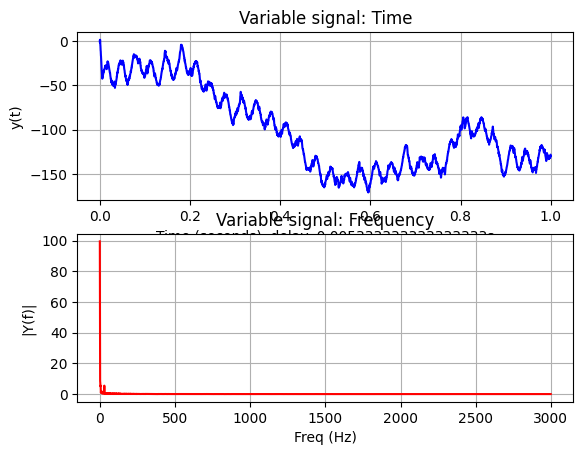

In [19]:
# Get phase of FM signal to get the variable signal
var_signal = Signal(
    np.unwrap(np.angle(fm_signal.samples)),
    fm_signal.rate,
    fm_signal.delay
)
plot_signal(var_signal, "Variable signal")

Bandpass filtering with 1453 taps


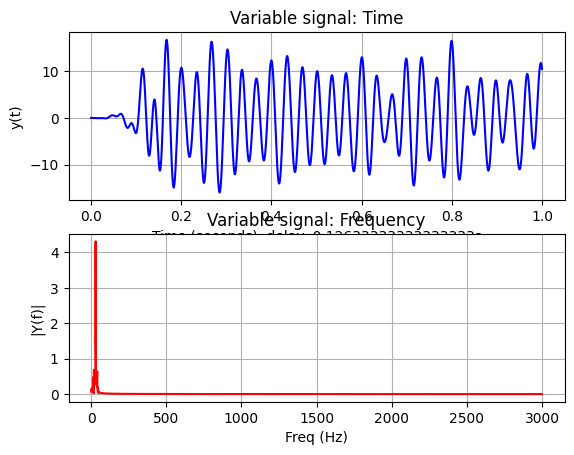

In [20]:
# Remove DC of variable signal
var_signal = bandpass(
    var_signal,
    width=15,
    attenuation=60,
    f1=15,
    f2=45
)

plot_signal(var_signal, "Variable signal")

Bearing: 221.4000000000001°


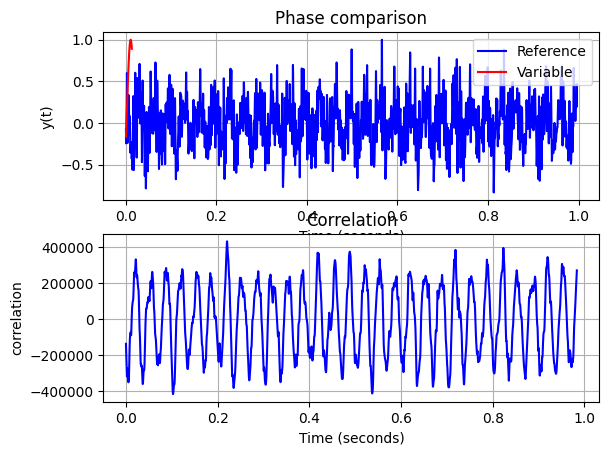

In [29]:
bearing = compare_phases(ref_signal, var_signal)
print("Bearing: {}°".format(bearing))

plt.show()